# Завантаження і первинна підготовка набору даних

In [2]:
import pandas as pd

df = pd.read_csv("Datasets/train_car_demand.csv")

df['date'] = pd.to_datetime(df['date'])

df = df.groupby('date')['demand'].sum().reset_index()

df.head()

,date,demand
0,2018-08-18,632
1,2018-08-19,1040
2,2018-08-20,835
3,2018-08-21,932
4,2018-08-22,944


In [3]:
df.isnull().sum()
df.dropna()

,date,demand
0,2018-08-18,632
1,2018-08-19,1040
2,2018-08-20,835
3,2018-08-21,932
4,2018-08-22,944
...,...,...
890,2021-02-24,1659
891,2021-02-25,1417
892,2021-02-26,1812
893,2021-02-27,2165


<Axes: xlabel='date'>

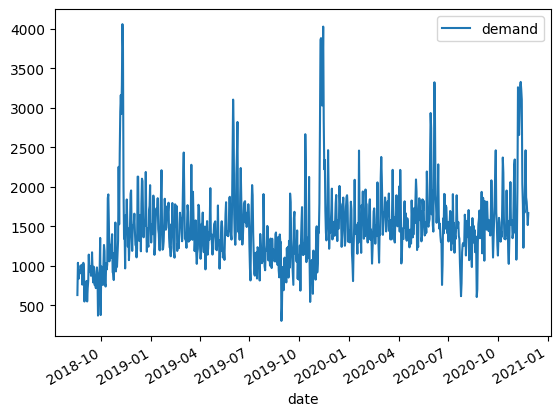

In [4]:
indices_to_drop = df[df['date'] > '2020-11-26'].index

df = df.drop(indices_to_drop)
df.plot(x='date', y='demand')

In [5]:
df.drop(columns=['date'], inplace=True)

df.head()

,demand
0,632
1,1040
2,835
3,932
4,944


## Підготовка даних для моделі LSTM

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Нормалізація даних
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Розділення: 80% train, 20% test
split_index = int(len(df_scaled) * 0.8)
train_data = df_scaled[:split_index]
test_data = df_scaled[split_index - 5:]  # захоплюємо 5 попередніх для створення першого вікна

# Функція для побудови послідовностей
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 5
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

# Перетворюємо у формат для LSTM (samples, timestamps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Створення та навчання моделі

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Модель
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=1)


Epoch 1/200


C:\Users\lysen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0809   
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 
Epoch 13/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 
Epoch 14/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 
Epoch 15/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 

# Тестування моделі

In [11]:
# Передбачення
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test)

# Результати
for i, (pred, real) in enumerate(zip(predictions, actual)):
    print(f"{i+1}) Передбачено: {pred[0]:.1f}, Факт: {real[0]:.1f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1) Передбачено: 1803.2, Факт: 2286.0
2) Передбачено: 2161.6, Факт: 1648.0
3) Передбачено: 1436.6, Факт: 1472.0
4) Передбачено: 1456.0, Факт: 1535.0
5) Передбачено: 1599.3, Факт: 1385.0
6) Передбачено: 1535.1, Факт: 1303.0
7) Передбачено: 1412.3, Факт: 1301.0
8) Передбачено: 1397.5, Факт: 760.0
9) Передбачено: 1043.9, Факт: 1013.0
10) Передбачено: 1162.3, Факт: 1602.0
11) Передбачено: 1549.5, Факт: 1412.0
12) Передбачено: 1376.8, Факт: 1912.0
13) Передбачено: 1728.4, Факт: 1907.0
14) Передбачено: 1700.4, Факт: 1473.0
15) Передбачено: 1419.2, Факт: 1764.0
16) Передбачено: 1726.5, Факт: 1742.0
17) Передбачено: 1703.2, Факт: 1513.0
18) Передбачено: 1549.9, Факт: 1413.0
19) Передбачено: 1441.9, Факт: 1557.0
20) Передбачено: 1612.0, Факт: 1310.0
21) Передбачено: 1422.8, Факт: 1559.0
22) Передбачено: 1585.8, Факт: 1539.0
23) Передбачено: 1533.7, Факт: 1696.0
24) Передбачено: 1678.8, Факт: 1551.0
25) Передбачено: 1489.7, Факт: 1200.0
26) Передбачено: 1285.

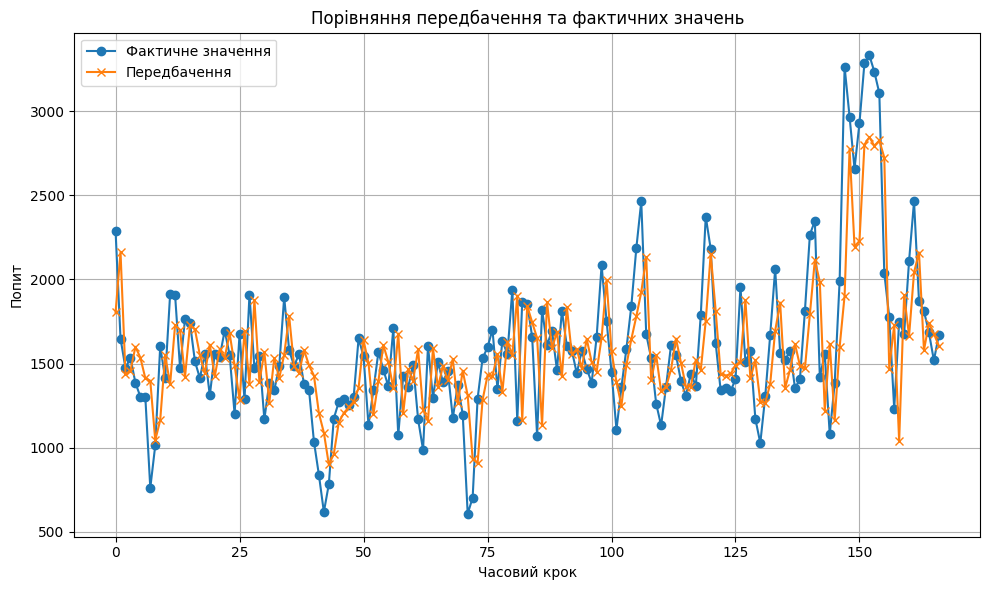

In [12]:
import matplotlib.pyplot as plt

# Створюємо списки значень для графіка
predicted = predictions.flatten()
actual_values = actual.flatten()

# Побудова графіка
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Фактичне значення', marker='o')
plt.plot(predicted, label='Передбачення', marker='x')
plt.title('Порівняння передбачення та фактичних значень')
plt.xlabel('Часовий крок')
plt.ylabel('Попит')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
